## Import modules and data

In [5]:
import numpy as np
import pandas as pd
import scipy.io
import community
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn import metrics

XYZ_Coord = scipy.io.loadmat('data/XYZcoord1.mat')
XYZ_C = np.array(XYZ_Coord ['XYZ1'])
print(XYZ_C)

XYZ_Edges = pd.read_csv('data/Edges.csv')
print(XYZ_Edges)

[[ 0.6851533   1.17897583  3.52402492]
 [ 1.00216962  1.21572705 29.32701994]
 [ 1.15125728  3.32476951 23.614195  ]
 ...
 [90.13576705 15.58773776 34.16825421]
 [90.73121678 16.76765189 13.4218382 ]
 [89.09981586 18.50040944 13.39066304]]
      Source  Target    Weight        Type
0          1       5  1.253704  Undirected
1          1      14  1.277093  Undirected
2          1      16  0.345464  Undirected
3          1      17  0.288327  Undirected
4          1      19  0.249381  Undirected
...      ...     ...       ...         ...
6031    1995    2000  0.104098  Undirected
6032    1996    1997  0.213520  Undirected
6033    1997    1999  0.154084  Undirected
6034    1997    2000  0.140709  Undirected
6035    1999    2000  0.420150  Undirected

[6036 rows x 4 columns]


## Calculate Euclidean distance and build graph

In [6]:
z = XYZ_C[:,2]
x = XYZ_C[:,0]
y = XYZ_C[:,1]
num = int((XYZ_C.shape[0] - 1) * XYZ_C.shape[0] * 0.5)
XYZ_E = np.zeros((num,3))
source = XYZ_Edges['Source'].to_numpy()
target = XYZ_Edges['Target'].to_numpy()
count = 0
for i in range(XYZ_C.shape[0]):
    for j in range(i+1, XYZ_C.shape[0]):
        distance = np.sqrt((x[i] - x[j])**2 + (y[i] - y[j])**2 + (z[i] - z[j])**2)
        XYZ_E[count][0] = i + 1
        XYZ_E[count][1] = j + 1
        XYZ_E[count][2] = 1 / distance
        count = count + 1
source = XYZ_E[:, 0]
target = XYZ_E[:, 1]
print(XYZ_E)
#Use pre-defined linkage (Edges.csv) to constructure whole network
G = nx.Graph()
for i in range(0, len(XYZ_E)):    
    e = ( str(int(XYZ_E[i,0])), str(int(XYZ_E[i,1])), XYZ_E[i,2] )
    G.add_weighted_edges_from([(e)])    

[[1.00000000e+00 2.00000000e+00 3.87522270e-02]
 [1.00000000e+00 3.00000000e+00 4.94809085e-02]
 [1.00000000e+00 4.00000000e+00 8.98288598e-02]
 ...
 [1.99800000e+03 1.99900000e+03 4.81035854e-02]
 [1.99800000e+03 2.00000000e+03 4.76047389e-02]
 [1.99900000e+03 2.00000000e+03 4.20149911e-01]]


## Use modularity to cluster and visualize

community: 5.0
modularity: 0.18388233609077567


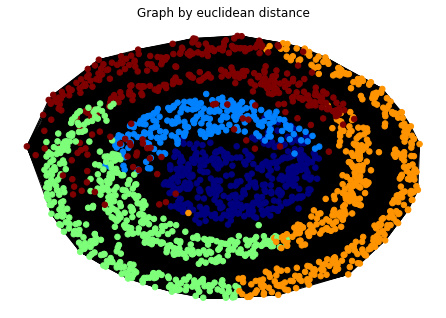

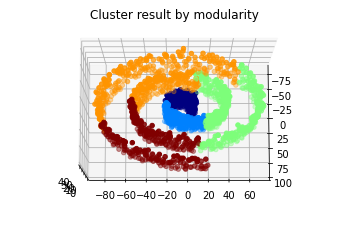

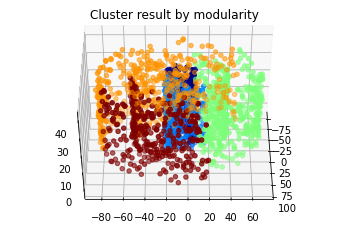

In [7]:
partition = community.best_partition(G)
size = float(len(set(partition.values())))
print("community:", size)
mod = community.modularity(partition,G)
print("modularity:", mod)

#assign node color based on community in network
for com in set(partition.values()) :
    #print("Community", com)
    members = list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
    #print(members)
values = [partition.get(node) for node in G.nodes()]
nx.draw_spring(G, cmap = plt.get_cmap('jet'), node_color = values, node_size = 30, with_labels = False)
plt.title('Graph by euclidean distance')
plt.show()    

#assign data point color based on community in realspace
label = np.zeros((len(XYZ_C),1))
for j in set(partition.values()) :
    for i in range(len(XYZ_C)) :
        if partition[str(i+1)] == j :            
            label[i] =  j
labelRE = np.reshape(label, len(XYZ_C))            

plt.figure(1)
ax = plt.axes(projection='3d')
z = XYZ_C[:,2]
x = XYZ_C[:,0]
y = XYZ_C[:,1]
c = labelRE
ax.scatter(x, y, z, c = c, cmap = plt.get_cmap('jet'))
ax.view_init(80, 0)
plt.title('Cluster result by modularity')


plt.figure(2)
ax = plt.axes(projection='3d')
z = XYZ_C[:,2]
x = XYZ_C[:,0]
y = XYZ_C[:,1]
c = labelRE
ax.scatter(x, y, z, c = c, cmap = plt.get_cmap('jet'))
ax.view_init(45, 0)
plt.title('Cluster result by modularity')
plt.show()

## Use Kmeans to cluster and visualize

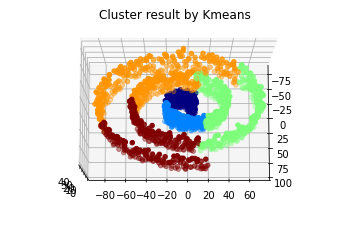

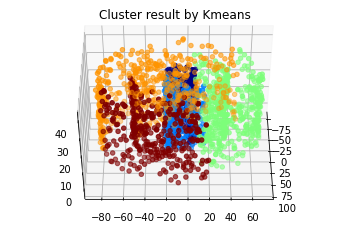

In [8]:
#KMeans area
best = -2
for j in range(int(size)):
    kmeans = KMeans(n_clusters = (j+1), max_iter = 1000).fit(XYZ_E)
    label = [0] * XYZ_C.shape[0]
    for i in range(len(label)) :
        label[i] = np.zeros((1, int(size))).astype(int)
    for i in range(kmeans.labels_.shape[0]) :
        label[int(source[i]-1)][0][kmeans.labels_[i]] = label[int(source[i]-1)][0][kmeans.labels_[i]] + 1
        label[int(target[i]-1)][0][kmeans.labels_[i]] = label[int(target[i]-1)][0][kmeans.labels_[i]] + 1
    for i in range(len(XYZ_C)) :
        label[i] = np.argmax(label[i][0])
    #labelRE = np.reshape(label, len(XYZ_C))
    avg = metrics.silhouette_score(XYZ_C, labelRE)
    if avg > best :
        best = avg
        final_label = labelRE
final_label = np.reshape(final_label, len(XYZ_C))

plt.figure(3)
ax = plt.axes(projection='3d')
z = XYZ_C[:,2]
x = XYZ_C[:,0]
y = XYZ_C[:,1]
c = final_label
ax.scatter(x, y, z, c = c, cmap = plt.get_cmap('jet'))
ax.view_init(80, 0)
plt.title('Cluster result by Kmeans')

plt.figure(4)
ax = plt.axes(projection='3d')
z = XYZ_C[:,2]
x = XYZ_C[:,0]
y = XYZ_C[:,1]
c = final_label
ax.scatter(x, y, z, c = c, cmap = plt.get_cmap('jet'))
ax.view_init(45, 0)
plt.title('Cluster result by Kmeans')
plt.show()